In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding
from scripts.text_proxy import TextProxy
from scripts.ref_proxy import RefProxy
from scripts.sketch_proxy import SketchProxy
from scripts.bald_proxy import BaldProxy
from scripts.color_proxy import ColorProxy
from scripts.feature_blending import hairstyle_feature_blending
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_base_models
from utils.options import Options

In [3]:
opts = Options().parse(jupyter=True)
src_name = '168125'# source image name you want to edit

image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
g_ema, mean_latent_code, seg = load_base_models(opts)
ii2s = Embedding(opts, g_ema, mean_latent_code[0,0])

Setting up Perceptual loss...
Loading model from: /workspaces/HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [17]:
if not os.path.isfile(os.path.join(opts.src_latent_dir, f"{src_name}.npz")):
    inverted_latent_w_plus, inverted_latent_F = ii2s.invert_image_in_FS(image_path=f'{opts.src_img_dir}/{src_name}.jpg')
    save_latent_path = os.path.join(opts.src_latent_dir, f'{src_name}.npz')
    np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                latent_F=inverted_latent_F.detach().cpu().numpy())
src_latent = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_in']).cuda()
src_feature = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_F']).cuda()
src_image = image_transform(Image.open(f'{opts.src_img_dir}/{src_name}.jpg').convert('RGB')).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

In [6]:
bald_proxy = BaldProxy(g_ema, opts.bald_path)
text_proxy = TextProxy(opts, g_ema, seg, mean_latent_code)
ref_proxy = RefProxy(opts, g_ema, seg, ii2s)
sketch_proxy = SketchProxy(g_ema, mean_latent_code, opts.sketch_path)
color_proxy = ColorProxy(opts, g_ema, seg)

edited_hairstyle_img = src_image
def hairstyle_editing(global_cond=None, local_sketch=False, paint_the_mask=False, \
                      src_latent=src_latent, src_feature=src_feature, input_mask=input_mask, src_image=src_image, \
                        latent_global=None, latent_local=None, latent_bald=None, local_blending_mask=None, painted_mask=None):
    if paint_the_mask:
        modified_mask = painting_mask(input_mask)
        input_mask = torch.from_numpy(modified_mask).unsqueeze(0).cuda().long().clone().detach()
        vis_modified_mask = vis_seg(modified_mask)
        display_image_list([src_image, vis_modified_mask])
        painted_mask = input_mask

    if local_sketch:
        latent_local, local_blending_mask, visual_local_list = sketch_proxy(input_mask)
        display_image_list(visual_local_list)
        
    if global_cond is not None:
        assert isinstance(global_cond, str)
        latent_bald, visual_bald_list = bald_proxy(src_latent)
        display_image_list(visual_bald_list)

        if global_cond.endswith('.jpg') or global_cond.endswith('.png'):
            latent_global, visual_global_list = ref_proxy(global_cond, src_image, painted_mask=painted_mask)
        else:
            latent_global, visual_global_list = text_proxy(global_cond, src_image, from_mean=True, painted_mask=painted_mask)
        display_image_list(visual_global_list)

    src_feature, edited_hairstyle_img = hairstyle_feature_blending(g_ema, seg, src_latent, src_feature, input_mask, latent_bald=latent_bald,\
                                                latent_global=latent_global, latent_local=latent_local, local_blending_mask=local_blending_mask)
    return src_feature, edited_hairstyle_img


Setting up Perceptual loss...
Loading model from: /workspaces/HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


## Hairstyle Editing

ref_loss: 0.0342;: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]


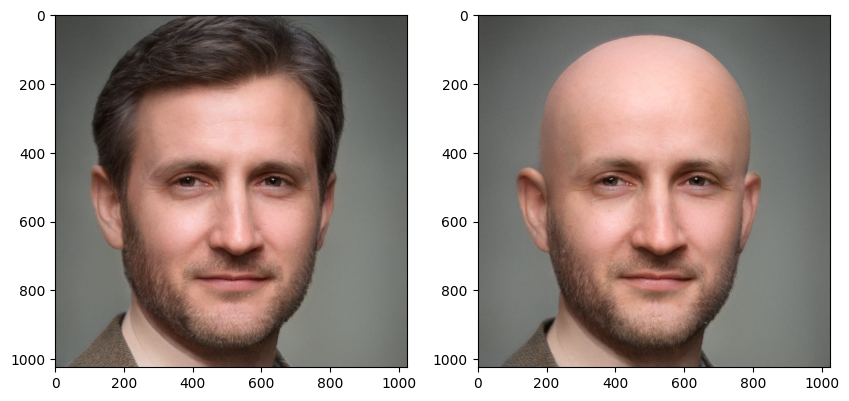

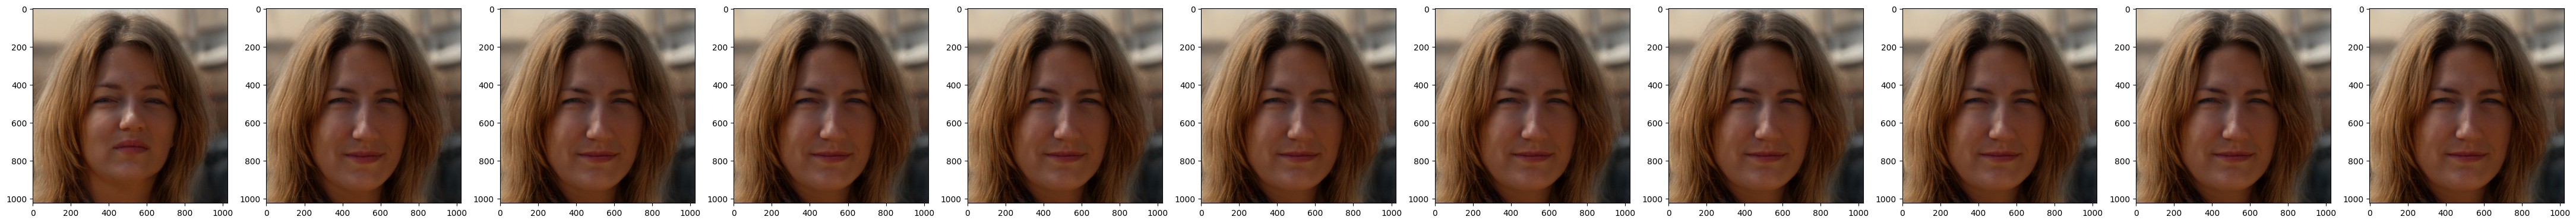

In [11]:
#global_cond: e.g. 'bowl cut hairstyle' for text_mode; '058728.jpg' for ref_mode
src_feature, edited_hairstyle_img = hairstyle_editing(global_cond='108157.jpg', local_sketch=False, paint_the_mask=False)

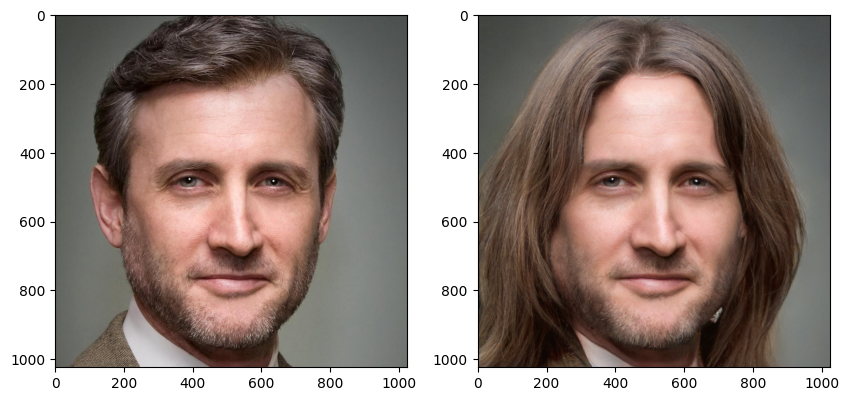

In [12]:
display_image_list([process_display_input(src_image), process_display_input(edited_hairstyle_img)])

In [14]:
edited_hairstyle_img.dtype

torch.float32

## Color Editing

final_loss: 0.0123;: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


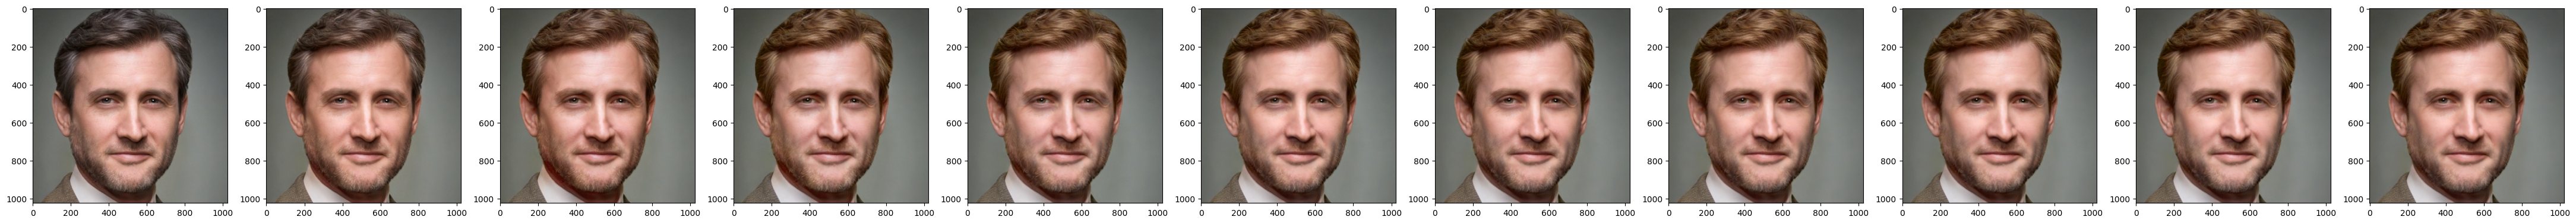

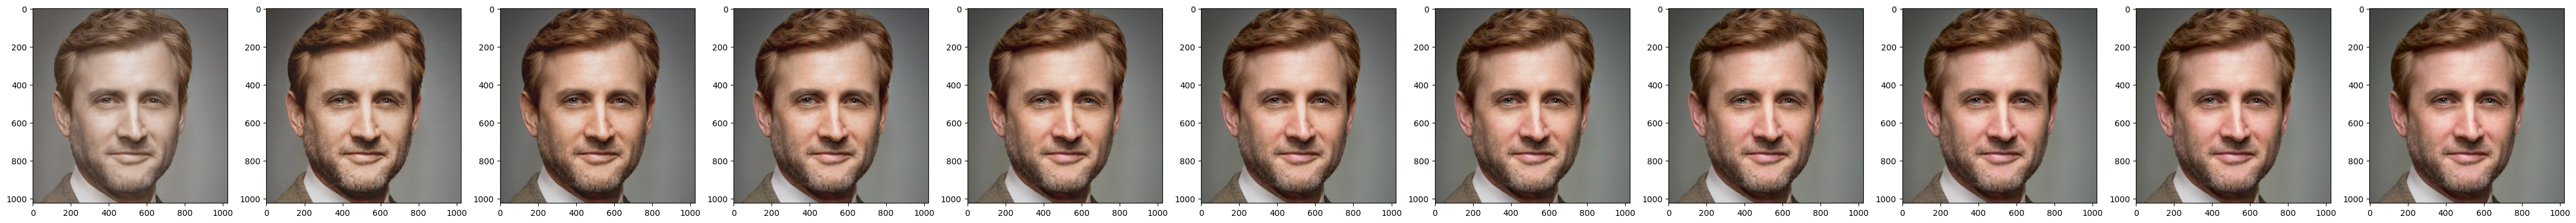

In [18]:
color_cond = '108157.jpg' #e.g. 'red hair' for text_mode; '108157.jpg' for ref_mode; (220,220,220) for RGB value mode

visual_color_list, visual_final_list = color_proxy(color_cond, src_image, src_latent, src_feature)
display_image_list(visual_color_list)
display_image_list(visual_final_list)

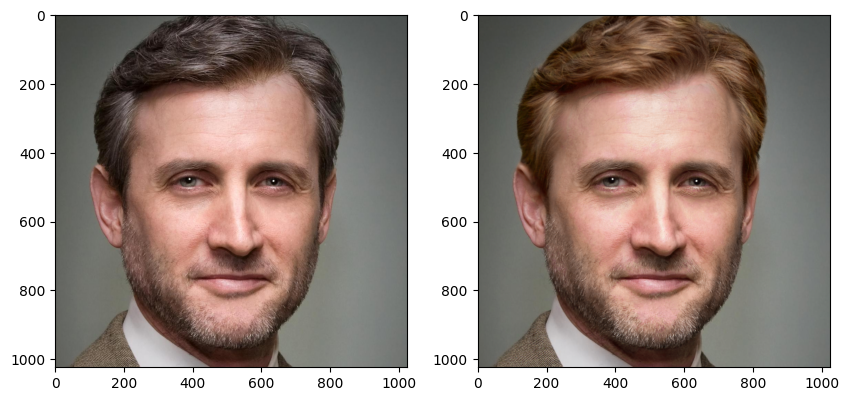

In [19]:
display_image_list([src_image, visual_final_list[-1]])